# Programmierübung 2 zu *Grundlagen der Optimierung* (WS2021)

## Einführung

### Verantwortlich
* Prof. Dr. Roland Herzog
* Dr. Georg Müller
* M.Sc. Masoumeh Hashemi

Die Webseite dieser Veranstaltung finden Sie unter [https://tinyurl.com/scoop-gdo](https://tinyurl.com/scoop-gdo).

### Zielsetzung
Das Ziel dieses *Jupyter Notebooks* ist es, Ihnen das Verhalten des Simplex-Algorithmus aus Kapitel 2 des Skripts zur Lösung linearer Optimierungsprobleme nahezubringen.
Wir werden
1. Das Simplex Verfahren mit zugehöriger Phase I und verschiedener Index-Auswahlverfahren implementieren
1. Die Implementierung testen
1. Den Einfluss zweier verschiedener Indexauswahlregeln auf den Simplex-Algorithmus untersuchen
1. Den Einfluss von der Wahl der Toleranzen im Simplex-Algorithmus untersuchen
1. Die Performance des Simplex-Algorithmus untersuchen
1. Tschebyschow-Zentren berechnen und visualisieren

### Zur Bedienung des Notebooks
Bitte schauen Sie [hier](https://scoop.iwr.uni-heidelberg.de/intro-jupyter/) unter dem Punkt "Bedienung" für mehr Informationen zur Nutzung und Bedienung des Notebooks.

## Implementierung des Simplex-Verfahrens für lineare Programme
In diesem Abschnitt implementieren wir das Simplex-Verfahren- den Kern dieser Programmierübung. 
Bevor wir mit dem Simplex selbst beginnen können, benötigen wir jedoch Auswahlverfahren für die Indizes, die anhand der reduzierten Kosten in die Basis aufgenommen werden bzw. anhand des Quotiententests aus der Basis entfernt werden.
Konkret wollen wir die folgenden Regeln implementieren:
1. Die Auswahlregel nach Bland für den in die Basis aufzunehmenden Index
1. Die Auswahlregel nach Bland für den aus der Basis zu entfernenden Index
1. Die Steepest-Descent-Auswahlregel, für den in die Basis aufzunehmenden Index, welche den Index mit dem kleinsten Eintrag im reduzierten Kostenvektor zurückgibt
1. Die Auswahlregel nach Bland für den in die Basis aufzunehmenden Index

**Aufgabe:** Vervollständigen Sie den Code und führen Sie die Zelle aus.

In [1]:
# This module implements index selection rules for the primal simplex method

import numpy as np

def blands_entering_rule(reduced_cost, tolerance):
	"""
	Accepts:
		       reduced_cost: the reduced cost vector of full length
		          tolerance: a tolerance on when to consider a reduced cost "actually" negative
	Returns: 
		       The lowest index with corresponding negative reduced cost entry
	"""
	return np.where(reduced_cost < -np.abs(tolerance))[0][0]

def blands_leaving_rule(restrictions):
	"""
	Accepts:
		       restrictions: the indices corresponding to the halfspaces restricting further movement along the update direction. These components will be zero in the iterate after the update was performed.
	Returns: 
		       The lowest index that restricts further movement
	"""
	return restrictions[0]

def steepest_descent_entering_rule(reduced_cost, tolerance):
	"""
	Accepts:
		       reduced_cost: the reduced cost vector of full length
		          tolerance: unused
	Returns: 
		       The index with lowest corresponding negative reduced cost entry
	"""
	return np.where(reduced_cost == min(reduced_cost))[0][0]

def largest_index_leaving_rule(restrictions):
	
	"""
	Accepts:
		       restrictions: the indices corresponding to the halfspaces restricting further movement along the update direction. These components will be zero in the iterate after the update was performed.
	Returns: 
		       The largest index that restricts further movement
	"""
	return restrictions[-1]


Jetzt, wo wir die Auswahlregeln zur Hand haben, folgt die Implementierung des Simplex-Algorithmus.

**Aufgabe:** Vervollständigen Sie den Code und führen Sie die Zelle aus.

In [2]:
# This module implements the primal simplex method for solving linear programs
# It consists of two functions: The "actual" simplex method in run_primal_simplex_method,
# which expects a basis for a initial feasible basic vector as input, and the wrapper
# primal_simplex_method, which will do a phase I if no initial basis was provided for
# the original problem.

import numpy as np

def primal_simplex_method(A, b, c, B = None, entering_rule = blands_entering_rule, leaving_rule = blands_leaving_rule, parameters={}):
	"""
	Solve a linear optimization problem in standard form, i.e., a problem of
	the form
		min c*x 
		s.t. Ax = b, x >= 0,
	using the primal simplex method with Bland's rule.
	
	This function wraps the actual simplex in order to include a phase-I-search, if 
	no initial feasible basic point is provided.
	
	Accepts:
		            c: the linear cost's vector
		            A: the constraint's matrix
		            b: the constraint's right-hand-side vector
		            B: basis indices for initial feasible basic vector
		               defaults to None, in which case a basis will be determined from a Phase I
		entering_rule: the rule that selects the index that enters the basis from the reduced cost vector
		 leaving_rule: the rule that selects the index that leaves the basis from the quotient vector
		   parameters: optional parameters (dictionary);
		               the following key/value pairs are evaluated:
		               ["max_iterations"]: maximum number of iterations
		                          ["tol"]: tolerance for optimality check on reduced cost vector entries and feasibility in phase I
		                    ["verbosity"]: "verbose" or "quiet"
		                 ["keep_history"]: whether or not to store the iteration history (0, 1 or 2)

	Returns:
		result: a dictionary containing the key/value pairs
		            solution: final iterate
		            function: the final iterate's objective value
		       basis_indices: the final iterate's basis indices
		          iterations: number of iterations performed
		            exitflag: flag encoding why the algorithm terminated
		                      0: optimal solution found
		                      1: problem is unbounded
		                      2: maximum number of iterations reached
		                      3: problem is infeasible (In which case all other fields of result will be None)  
	"""
	# Check some parameter requirements and set to default if not provided
	verbosity = parameters.get("verbosity", "quiet")
	tol = parameters.get("tol", 0)
	
	# If initial basis for feasible basic vector was not provided, find one in phase I
	if B is None:
		# Dump some output
		if verbosity == 'verbose':
			print("No initial basis provided. Starting phase I.")
		
		# Get problem dimensions
		m, n = A.shape
		
		# Generate input data for the phase-I-problem
		A_I = np.hstack((A, np.diag(np.where(b >= 0, 1, -1))))
		b_I = b
		c_I = np.hstack((np.zeros(n), np.ones(m)))
		B_I = range(n, n+m)

		# Solve phase-I-problem
		phase_I_result = run_primal_simplex_method(A_I, b_I, c_I, B_I, entering_rule, leaving_rule, parameters)
		
		# Check if phase I terminated correctly
		if phase_I_result["exitflag"] == 2:
			raise BaseException("Phase I terminated because the maximum number of iterations were performed.")
		
		if phase_I_result["exitflag"] == 1:
			raise BaseException("Phase I terminated because the problem was detected as unbounded.")
		
		# Check for feasibility of the initial problem
		if any(phase_I_result["solution"][n:] > np.abs(tol)):
			result = {
				"solution" : None,
				"function" : None,
				"basis_indices" : None,
				"iterations" : None,
				"exitflag" : 3
			}
			
			# Dump some output
			if verbosity == 'verbose':
				print('\n\nOriginal problem was found to be infeasible in phase I. Phase II won\'t be performed.\n')
				
			return result
		
		# Get initial basis for phase II from solution of phase I
		B = list(set(phase_I_result["basis_indices"]))
		N_real = list(set(range(n)) - set(B))

		# Remove all unwanted artificial indices from basis in case of degeneracy (postprocessing)
		try:
			# Get largest basis index
			max_basis_index = max(B)
			
			# If largest basis index is artificial, swap it out
			while max_basis_index >= n:  
				# Obtain representations for nonbasic columns of A in current basis
				D = np.linalg.solve( A_I[:,B], A[:,N_real] )
				
				# Determine swap index as the largest of the ones contributing most to e_max_basis_index (guaranteed to be nonzero)
				entering_basis = N_real[np.argmax(np.abs(D[np.where(np.array(B, copy=False)  == max_basis_index)[0],:]))]
				
				# Swap out largest index in B
				B = list(set(B) - set([max_basis_index]) | set([entering_basis]))
				
				if verbosity == 'verbose':
					print("Replaced artificial basis index %4d with real index %4d." % (max_basis_index, entering_basis))
				
				# Get new largest basis index
				max_basis_index = max(B)
		except:
			raise ValueError("Index swap failed in phase-I-post-processing.") 
			
	else: # B was not None
		# Dump some output
		if verbosity == 'verbose':
			print("Initial basis provided.")
	
	# Run the phase II optimization
	if verbosity == 'verbose':
		print("\nStarting Optimization.")
	result = run_primal_simplex_method(A, b, c, B, entering_rule, leaving_rule, parameters)

	return result
	
def run_primal_simplex_method(A, b, c, B, entering_rule, leaving_rule, parameters):
	"""
	Solve a linear optimization problem in standard form, i.e., a problem of
	the form
		min c*x 
		s.t. Ax = b, x >= 0,
	using the primal simplex method with Bland's rule.
	Expects a Basis for an initial feasible basic point to be supplied.

	Accepts:
		            c: the linear cost's vector
		            A: the constraint's matrix
		            b: the constraint's right-hand-side vector
		            B: basis indices for initial feasible basic vector
		   parameters: optional parameters (dictionary);
		entering_rule: the rule that selects the index that enters the basis from the reduced cost vector
		 leaving_rule: the rule that selects the index that leaves the basis from the quotient vector
		   parameters: optional parameters (dictionary);
		               the following key/value pairs are evaluated:
		               ["max_iterations"]: maximum number of iterations
		                          ["tol"]: tolerance for optimality check on reduced cost vector entries and feasibility in phase I
		                    ["verbosity"]: "verbose" or "quiet"
		                 ["keep_history"]: whether or not to store the iteration history (True or False)

	Returns:
		       result: a dictionary containing the key/value pairs
		                    solution: final iterate
		                    function: the final iterate's objective value
		               basis_indices: the final iterate's basis indices
		                  iterations: number of iterations performed
		                    exitflag: flag encoding why the algorithm terminated
		                              0: optimal solution found
		                              1: problem is unbounded
		                              2: maximum number of iterations reached
	"""

	def print_header(): 
		print('----------------------------------------------------------------------------------------------')
		print(' ITER          OBJ      OBJCHNG   MINREDCOST   CHSREDCOST     ENTERING      LEAVING           ')
		print('----------------------------------------------------------------------------------------------')

	# Get the algorithmic parameters, using defaults if missing
	max_iterations = parameters.get("max_iterations", 1e3)
	tol = parameters.get("tol", 0)
	verbosity = parameters.get("verbosity", "quiet")
	keep_history = parameters.get("keep_history", False)

	# Define exitflags that will be printed when the algorithm terminates
	exitflag_messages = [
		'Reached optimal solution.',		
		'Problem is unbounded.',
		'Reached maximum number of optimization steps.',
	]

	# Get problem dimensions
	m, n = A.shape

	# Remove all duplicate indices from initial basis and check length
	B = list(set(B))
	if len(B) != m:
		raise ValueError("Size of initial basis does not match problem dimension")

	# Initialize initial iterate and non-basis index set from initial basis
	x = np.zeros(n)
	try:
		x[B] = np.linalg.solve(A[:,B], b)
	except: 
		raise ValueError("Could not compute iterate from basis.")
	N = list(set(list(range(n))) - set(B))
	
	# Check the initial iterate for feasibility
	if any(x < 0): 
		raise ValueError("Initial iterate is infeasible.")

	# Initialize variables for simplex iteration loop
	iterations = 0
	exitflag = None
	f_old = np.inf

	# Prepare a dictionary to store the history
	if keep_history:
		history = {
			"iterates" : [],
			"objective_values" : [],
			"basis_indices" : [],
			"entering_basis" : [],
			"leaving_basis" : []
		}

	# Perform simplex iterations until termination criterion is met
	while exitflag is None:

		# Compute current function value 
		f = c.T @ x

		# Record the current iterate, its function value and the basis
		if keep_history: 
			history["iterates"].append(x.copy())
			history["objective_values"].append(f)
			history["basis_indices"].append(B)

		# Dump some output
		if verbosity == 'verbose':
			if (iterations%10 == 0): print_header()
			print(' %4d  %11.4e  %11.4e' % (iterations, f, f-f_old), end = '')

		# Stop when the maximum number of iterations has been reached
		if iterations >= max_iterations:
			exitflag = 2
			break

		try:
			# Compute reduced cost vector (sN)
			reduced_cost = np.zeros(n)
			reduced_cost[N] = c[N] - A[:,N].T @ np.linalg.solve(A[:,B].T, c[B])
		except:
			raise ValueError("Reduced cost vector could not be computed.")

		# Dump some output
		if verbosity == 'verbose': 
			print('  %11.4e' % (np.amin(reduced_cost)), end = '')

		# Check for optimality by checking sign of reduced cost vector entries
		# and also check if numerical inaccuracy is prohibiting proper termination 
		if all(reduced_cost >= -np.abs(tol)):
			exitflag = 0
			break

		# Remember function value
		f_old = f

		# Select new entering basis index using Bland's rule
		entering_basis = entering_rule(reduced_cost, tol)
		
		# Dump some output
		if verbosity == 'verbose': 
			print('  %11.4e' % (reduced_cost[entering_basis]), end = '')

		# Record the index that enters_basis 
		if keep_history: history["entering_basis"].append(entering_basis)

		# Dump some output
		if verbosity == 'verbose': print('         %4d  ' % (entering_basis), end = '')

		# Compute update direction
		delta_x = np.zeros(n)
		try:
			delta_x[B] = - np.linalg.solve(A[:,B], A[:,entering_basis])
		except:
			raise ValueError("Update direction could not be computed.")

		# Check for unboundedness
		if all(delta_x >= -np.abs(tol)):
			exitflag = 1
			break

		# Compute steplength from quotient test
		quotients = np.full(n, np.inf)
		quotients[delta_x < -np.abs(tol)] = -x[delta_x < -np.abs(tol)] / delta_x[delta_x < -np.abs(tol)]
		step_length = np.amin(quotients)
		
		# Compute index that will leave the basis
		leaving_basis = leaving_rule(np.where(quotients == step_length)[0])

		# Record the leaving basis index
		if keep_history: history["leaving_basis"].append(leaving_basis)

		# Dump some output
		if verbosity == 'verbose': print('       %4d  ' % (leaving_basis))
		
		# Update iterate
		x[B] = x[B] + step_length * delta_x[B]
		x[leaving_basis] = 0
		x[entering_basis] = step_length

		# Update basis and nonbasis
		B = list(set(B) - set([leaving_basis]) | set([entering_basis]))
		N = list(set(N) - set([entering_basis]) | set([leaving_basis]))

		iterations = iterations + 1 

	# Dump some output
	if verbosity == 'verbose':
		print('\n\nThe simplex method is exiting with flag %d.\n' %(exitflag) + str(exitflag_messages[exitflag])+'\n' )

	# Create and populate the result to be returned
	result = {
		"solution" : x,
		"function" : c.T @ x,
		"basis_indices" : B,
		"iterations" : iterations,
		"exitflag" : exitflag
	}

	# Assign the history to the result if required
	if keep_history: result["history"] = history

	return result


## Test der Simplex-Implementierung
Die Implementierung des Simplex hat einige Fallunterscheidungen anzustellen. 
Um zu überprüfen, ob Ihre Implementierung (weitestgehend) korrekt ist, stellen wir Ihnen in der nächsten Zelle ein paar Testfälle zur Verfügung, anhand derer sie ihre Implementierung testen können.

**Aufgabe:** Führen Sie die unten Zelle aus, und prüfen Sie, ob ihr Simplex die Testfälle lösen kann.

In [3]:
# This script tests the simplex method for various scenarious for debugging purposes
# The following tests are performed using bland's rule for entering and exiting:
# 1. Can the simplex method detect an infeasible initial basis correctly (Mozart problem)
# 2. Can the Mozart problem be solved correctly from given initial basis
# 3. Can the Mozart problem be solved correctly with a phase I search beforehand to compute initial basis
# 4. Check if Phase I can detect infeasibility of the problem correctly (infeasibly modified Mozart problem)
# 5. Check if a degenerate basis returned from Phase I is modified to be feasible  for phase II in post-processing

# Not checked: Detection of unboundedness of the initial problem

import numpy as np

# Set parameters for simplex method
simplex_parameters = {
	"max_iterations" : 1000,
	"verbosity" : "verbose",
	"keep_history" : True
}

# Define the mozart problem
A_mozart = np.array([[1, 1, 1, 0, 0],
                     [2, 1, 0, 1, 0],
                     [1, 2, 0, 0, 1]])
c_mozart = np.array([-9, -8, 0, 0, 0])
b_mozart = np.array([6, 11, 9])

# Modify the Mozart problem to become infeasible by fixing x_1 to -1
A_mozart_infeasible = np.vstack((A_mozart, [1, 0, 0, 0, 0]))
b_mozart_infeasible = np.hstack((b_mozart, [-1]))

# Define a problem that requires post processing of phase I result
n = 10
m = 8
A_post_processing = -np.hstack((np.eye(m),np.ones((m,n-m))))
b_post_processing = np.zeros(m)
c_post_processing = np.ones(n)

# Start checking
# Check if infeasible initial point is detected
print('###### Check 1: Checking if infeasible initial point is detected')
try:
	result = primal_simplex_method(A_mozart, b_mozart, c_mozart, B = [0, 3, 4], parameters = simplex_parameters)
except ValueError as err:
	print("Simplex error: {0}\n".format(err))
	if(str(err) == "Initial iterate is infeasible."):
		print("-----> Check 1 passed")
	else:
		raise BaseException("Infeasible initial basis not handled correctly")
	
# Check if mozart problem can be solved correctly
print('###### Check 2: Checking if Mozart problem can be solved correctly from feasible point')
result = primal_simplex_method(A_mozart, b_mozart, c_mozart, B = [0, 2, 4], parameters = simplex_parameters)
if result["exitflag"] == 0 and set(result["basis_indices"]) == {0, 1, 4}: 
	print("-----> Check 2 passed")
else:
	raise BaseException("Mozart problem not solved correctly")

# Check if phase I works without degeneracy in the phase I solution basis
print('###### Check 3: Checking if phase I works without degeneracy in the phase I solution basis')
result = primal_simplex_method(A_mozart, b_mozart, c_mozart, B = None, parameters = simplex_parameters)
if result["exitflag"] == 0 and set(result["basis_indices"]) == {0, 1, 4}: 
	print("-----> Check 3 passed")
else:
	raise BaseException("Mozart problem not solved correctly including phase I")

# Check detecting of infeasibility in phase I
print('###### Check 4: Checking if infeasibility in problem is detected')
result = primal_simplex_method(A_mozart_infeasible, b_mozart_infeasible, c_mozart, B = None, parameters = simplex_parameters)
if result["exitflag"] == 3:
	print("-----> Check 4 passed")
else:
	raise BaseException("Infeasiblity not handled correctly")

# Check if degenerate basis in phase I is handled correctly
print('###### Check 5: Checking if degenerate phase I basis is handled correctly')
result = primal_simplex_method(A_post_processing, b_post_processing, c_post_processing, B = None, parameters = simplex_parameters)
if all(np.array(result["basis_indices"]) < n):
	print("-----> Check 5 passed")
else:
	raise BaseException("Degenerate phase I basis not handled correctly")


###### Check 1: Checking if infeasible initial point is detected
Initial basis provided.

Starting Optimization.
Simplex error: Initial iterate is infeasible.

-----> Check 1 passed
###### Check 2: Checking if Mozart problem can be solved correctly from feasible point
Initial basis provided.

Starting Optimization.
----------------------------------------------------------------------------------------------
 ITER          OBJ      OBJCHNG   MINREDCOST   CHSREDCOST     ENTERING      LEAVING           
----------------------------------------------------------------------------------------------
    0  -4.9500e+01         -inf  -3.5000e+00  -3.5000e+00            1            2  
    1  -5.3000e+01  -3.5000e+00   0.0000e+00

The simplex method is exiting with flag 0.
Reached optimal solution.

-----> Check 2 passed
###### Check 3: Checking if phase I works without degeneracy in the phase I solution basis
No initial basis provided. Starting phase I.
--------------------------------------

## Einfluss der Index-Auswahlregeln
Die obigen Tests wurden mit den Auswahlregeln von Bland durchgeführt, die in der Veranstaltung besprochen wurde. 
Wir wollen jetzt an einem ausgewählten Beispiel das Verhalten der beiden Verfahren gegenüberstellen.

**Aufgabe:** Lösen Sie das unten stehende Problem mit Ihrem Simplex Verfahren -- einmal für die Index-Auswahlverfahren-Kombination Steepest-Descent für *entering* und der Regel von Bland für *leaving* sowie einmal für die Regel von Bland (sowohl für *entering* und *leaving*) -- indem Sie die nächste Zelle ausführen.

In [4]:
# Set parameters for the simplex method
simplex_parameters = {
	"max_iterations" : 20,
	"verbosity" : "verbose",
	"keep_history" : True
}

# Set the data
A = np.array([[0.25, -8, -1,   9, 1, 0, 0],
             [0.5, -12, -0.5, 3, 0, 1, 0],
             [0,     0,  1,   0, 0, 0, 1]])
c = np.array([-0.75, 20, -0.5, 6, 0 ,0, 0])
b = np.array([0, 0, 1])

# Solve the problem using steepest descent rule in simplex algorithm
result_steepest_descent = primal_simplex_method(A, b, c, B = [4, 5, 6], entering_rule = steepest_descent_entering_rule, parameters = simplex_parameters)

# Solve the problem using bland
result_bland = primal_simplex_method(A, b, c, B = [4, 5, 6], parameters = simplex_parameters)


Initial basis provided.

Starting Optimization.
----------------------------------------------------------------------------------------------
 ITER          OBJ      OBJCHNG   MINREDCOST   CHSREDCOST     ENTERING      LEAVING           
----------------------------------------------------------------------------------------------
    0   0.0000e+00         -inf  -7.5000e-01  -7.5000e-01            0            4  
    1   0.0000e+00   0.0000e+00  -4.0000e+00  -4.0000e+00            1            5  
    2   0.0000e+00   0.0000e+00  -2.0000e+00  -2.0000e+00            2            0  
    3   0.0000e+00   0.0000e+00  -3.0000e+00  -3.0000e+00            3            1  
    4   0.0000e+00   0.0000e+00  -1.0000e+00  -1.0000e+00            4            2  
    5   0.0000e+00   0.0000e+00  -2.0000e+00  -2.0000e+00            5            3  
    6   0.0000e+00   0.0000e+00  -7.5000e-01  -7.5000e-01            0            4  
    7   0.0000e+00   0.0000e+00  -4.0000e+00  -4.0000e+00        

**Aufgabe:** Beschreiben Sie Ihre Beobachtung zum Verhalten des Algorithmus in beiden Fällen. Inwiefern entspricht das Ihrer Erwartung?

**TODO Ihre Antwort hier**

In der Steepest-Descent Variante stellen wir fest, dass die maximale Anzahl der Iterationen ausgenutzt wird, ohne dass sich am Kostenfunktional etwas ändert, obwohl die reduzierten Kosten zum Basis betretenden Index offensichtlich negativ sind und nicht im Bereich numerischer Fehler liegen. 
Das Verfahren tauscht also nur Basisindizes an einer degenerierten Ecke ohne, dass Fortschritt entsteht.

Schauen wir uns die ein- und ausgetauschen Basisindizes an, dann stellen wir fest, dass alle 5 Iterationen die Indexwahlfolge
\begin{align*}
\text{ENTERING} \quad    &&\text{LEAVING}\\
       0     \quad && 4  \\
       1     \quad && 5  \\
       2     \quad && 0  \\
       3     \quad && 1  \\
       4     \quad && 2  \\
       5     \quad && 3
\end{align*}
stattfindet, welche aus der Startbasis $\{4,5,6\}$ wieder die Ausgangsbasis macht (Jeder *entering* Index wird in der übernächsten Iteration wieder als *leaving* aus der Basis geschmissen und am Ende werden die Indizes 4 und 5, die am Anfang aus der Basis entfernt wurden, wieder in die Basis gesteckt). 
Der Algorithmus startet also in einen Zyklus von Länge 6 und bleibt dort hängen.

In der Lösung mit der Regel von Bland werden die ersten 4 Iterationen genauso ausgeführt, doch bevor das Ursprungspaar (4,5) wieder in die Basis getauscht wird, wie im Steepest Descent Fall, werden wieder andere Indexkombinationen gewählt, die nach 2 weiteren Schritten zur Terminierung im Optimierer führen.

Das beobachtete Verhalten ist insofern zu erwarten gewesen, dass wir bei der Regel von Bland Zyklen ausschließen können -- bei der Steepest-Descent Regel hingegen nicht. 
Wir wissen auch, dass Zyklen mindestens Länge 3 haben, das konnten wir hier auf beobachten. Außerdem konnten wir auch hier sehen, dass Zyklen nur auftreten können, wenn die Iterierte eine degenerierte Ecke ist.

## Toleranzen in der Implementierung
Bisher haben wir alle Berechnungen mit Algorithmusparametern durchgeführt, die keine Toleranzen berücksichtigt haben. Das war bei den obigen Problemen kein Problem, im Allgemeinen muss das aber keine gute Idee sein, wie wir hier sehen werden.

**Aufgabe:** Führen Sie die nachfolgende Zelle aus.

In [5]:
# This script visualizes the degenerate behavior of the simplex algorithm when tolerances are set to 0.
# We solve a number of random examples until we find one where we expect numerical issues and rerun that
# example again in verbose mode to analyze the output
import sys
sys.path.append('src/')
from visualization_functions import *

# Set parameters for simplex method
simplex_parameters = {
	"max_iterations" : 150,
	"verbosity" : "quiet",
	"keep_history" : False
}

# Set parameters for random testing
max_n = 50
min_n = 5
max_random_entry = 10

# Create pseudo random number generator with reproducable seed
np.random.seed(0)
rng = np.random.default_rng(np.random.MT19937(seed=0))

#Get pseudo random data sizes from sampling
number_of_samples = 1000
N = rng.integers(min_n,max_n+1,number_of_samples)
M = rng.integers(1, N, number_of_samples)

# Solve test instances until we find one that needs max iterations
for n, m in zip(N, M):
	# Dump some output
	print('######################### Trying out n = %d, m = %d #########################' % (n,m))
	
	# Create pseudo random optimizer data (primal and dual)
	x_opt = np.hstack((np.zeros(m), max_random_entry * rng.random(n-m)))
	s_opt = np.hstack((max_random_entry * rng.random(m), np.zeros(n-m)))
	lam = max_random_entry * (rng.random(m) - 0.5)
	
	# Create pseudo random constraint matrix
	A = np.hstack((np.eye(m), rng.random((m, n-m))))
	
	# Create constraint rhs
	b = A @ x_opt
	
	# Create cost functional for which x_opt is an optimizer
	c = A.T @ lam + s_opt
	
	# Create basis
	B = np.arange(0, m)
	
	# Compute optimal function value
	f_opt = c @ x_opt

	# Start simplex iterations and store results plus problem dimensions
	result = primal_simplex_method(A, b, c, B, parameters = simplex_parameters)
	
	if result["exitflag"] == 2:
		print('Maximum iterations needed. Running again in verbose mode.')
		break;

# Rerun the example in verbose mode
simplex_parameters["verbosity"] = 'verbose'
result = primal_simplex_method(A, b, c, B, parameters = simplex_parameters)

######################### Trying out n = 27, m = 12 #########################
Maximum iterations needed. Running again in verbose mode.
Initial basis provided.

Starting Optimization.
----------------------------------------------------------------------------------------------
 ITER          OBJ      OBJCHNG   MINREDCOST   CHSREDCOST     ENTERING      LEAVING           
----------------------------------------------------------------------------------------------
    0   1.8631e+03         -inf  -3.5410e+01  -2.4447e+01           12            5  
    1   1.0725e+03  -7.9066e+02  -2.7501e+01  -6.6896e+00           13            8  
    2   9.2522e+02  -1.4726e+02  -2.1775e+01  -8.0460e+00           14            2  
    3   9.1874e+02  -6.4798e+00  -2.4819e+01  -3.8210e+00            8           11  
    4   8.6958e+02  -4.9159e+01  -2.2305e+01  -9.5124e+00           15           13  
    5   8.1112e+02  -5.8467e+01  -2.6130e+01  -5.8192e+00            5            9  
    6   7.6716e

**Aufgabe:** Beschreiben Sie das beobachtete Verhalten und geben Sie eine Begründung für das Verhalten.

**TODO Ihre Antwort hier**

Wir können beobachten, dass in dem Testbeispiel die maximale Anzahl der Iterationen genutzt wird, ohne dass der Algorithmus von sich aus terminiert. 
In den letzten Iterationen sehen wir, dass immer wieder die Indizes 12 und 19 gegeneinander aus der bzw. in die Basis getauscht werden. 
Das Kostenfunktional ändert sich entweder kaum und es tritt teilweise sogar Aufstieg auf. 
Die reduzierten kosten sind in der Größenordnung der Maschinengenauigkeit.

Wir wissen, dass Zykel im Simplex-Verfahren mindestens Länge 3 haben, und dass das Simplex-Verfahren in jeder Iteration entweder Abstieg produziert oder keine Funktionswertänderung liefert. 
Beide Ergebnisse sind hier nicht zu beobachten -- entweder hat also der Code noch einen Bug, oder es liegen numerische Probleme vor. 
Nach 40 Iterationen mit vernünftigen Werten, springen die reduzierten Kosten plötzlich in die Größenordnung der Maschinengenauigkeit, die getauschten Indizes zykeln mit Länge 2 und es folgt gelegentlicher Aufstieg im Kostenfunktional. 
Das spricht ganz stark für numerische Ungenauigkeiten, die bei der zufälligen Wahl der Daten auftreten. 
Das Simplex-Verfahren ist ziemlich sensibel gegenüber Rundungsfehlern. 
Es realisiert in dem obigen Fall nicht, dass es nach den 40 Iterationen schon den Minimierer gefunden hat und bricht daher nicht ab. 
Einführen einer Toleranz beim Prüfen ob Optimalität, bei der Auswahl der Neuen (Nicht-)Basisindizes und beim infeasibility-Check stabilisiert das Verfahren erheblich. 
Was man hier aber wählt und welche Fälle man genau abdecken möchte, ist nicht so einfach zu bestimmen und mit eine der Stellschrauben, die in kommerzieller oder hochentwickelter Software modifiziert werden können.

## Simplex-Performance
Wir wissen aus dem Skript bereits, dass das Simplex-Verfahren zwar meist "schnell" doch manchmal "langsam" ist. 
Konkreter ist der worst-case Zusammenhang der Simplex-Iterationen und der Raumdimension midnestens exponentiell. 
Das Beispiel, dass das zeigt ist der *Klee-Minty Würfel* mit einem dazugehörigen Kostenvektor. 
Eine Variante des Problems ist das Folgende:

\begin{align*}
    \text{Maximiere} \quad
    &
    2^{n-1} x_1 + 2^{n-2} x_2 + \ldots + 2 x_{n-1} + x_n  
    \quad \text{über } x\in\mathbb{R}^n
   \\
    \text{sodass} \quad
    &
    \begin{alignedat}{10}
             x_1     &   &             &   &        &   &           &   &     & \leq & 5 \\
			 4x_1    & + & x_2         &   &        &   &           &   &     & \leq & 25 \\
			 8x_1    & + & 4x_2        & + & x_3    &   &           &   &     & \leq & 125 \\
			 \vdots  &   &             &   &        &   &           &   &     &      & \vdots \\
			 2^n x_1 & + & 2^{n-1} x_2 & + & \ldots & + & 4 x_{n-1} & + & x_n & \leq & 5^n \\
    \end{alignedat}
    \\
    \text{und }\quad & x \geq 0.
\end{align*}

**Aufgabe:** Vervollständigen Sie den Code in der folgenden Zelle um das Problem von Klee-Minty in so vielen wachsenden Raumdimensionen zu lösen, wie es Ihr Rechner in vernünftiger Zeit hergibt (die Laufzeit steigt exponentiell! Viele werden es nicht sein) und führen Sie die Zelle aus.

Iterations required to solve problem with cube dimension    2: 3
Iterations required to solve problem with cube dimension    3: 7
Iterations required to solve problem with cube dimension    4: 15
Iterations required to solve problem with cube dimension    5: 31
Iterations required to solve problem with cube dimension    6: 63
Iterations required to solve problem with cube dimension    7: 127
Iterations required to solve problem with cube dimension    8: 255
Iterations required to solve problem with cube dimension    9: 511
Iterations required to solve problem with cube dimension   10: 1023


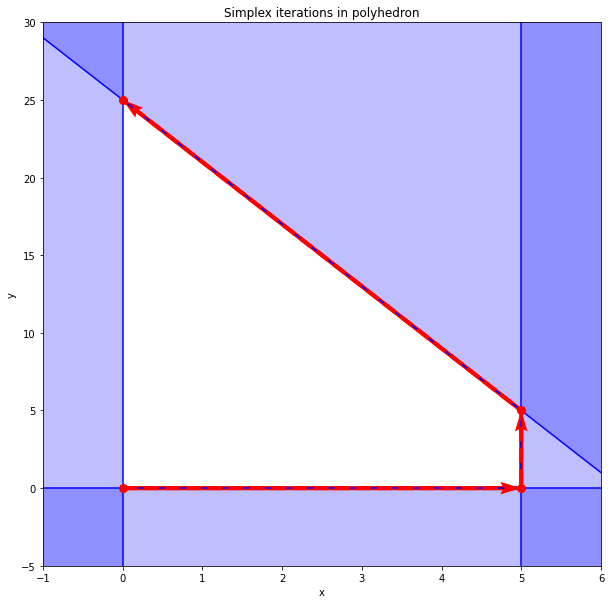

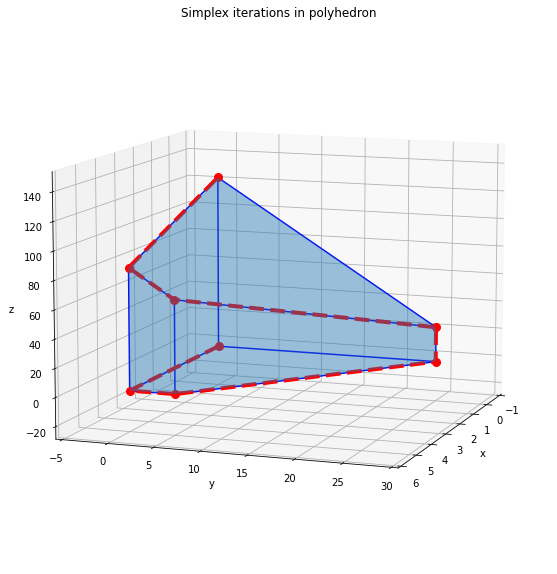

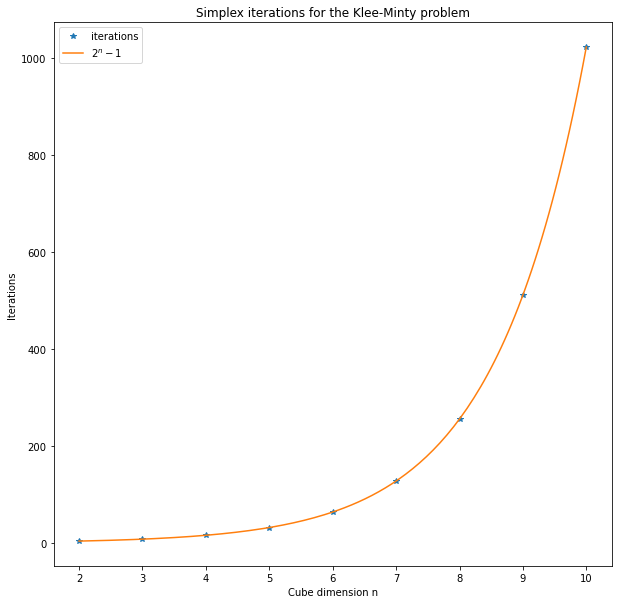

In [6]:
# This script illustrates the simplex algorithm's bad case complexity on a Klee-Minty cube

from visualization_functions import *

# Set maximum cube dimension (actual spatial dimension, not problem size n in normal form)
cube_max_dim = 10

# Set parameters for simplex method
simplex_parameters = {
	"max_iterations" : 2**cube_max_dim,
	"tol" : 1e-15,
	"verbosity" : "quiet",
	"keep_history" : True
}

# Initialize container for the iterations needed
iterations = []
dimensions = range(2, cube_max_dim+1)

for n in dimensions:
	# Set the data for the cube
	A = np.hstack((np.eye(n), np.eye(n)))
	for i in range(1, n):
		A[i,0:i] = np.power(2, np.arange(i,0,-1)+1)
	b = np.power(5, np.arange(1, n+1))
	
	# Set the cost functional vector
	c = - np.hstack((np.power(2, np.arange(n-1, -1, -1)), np.zeros(n)))
	
	# Set initial basis
	initial_basis = list(range(n, 2*n))
		
	# Solve the problem using steepest descent
	result = primal_simplex_method(A, b, c, B = initial_basis, entering_rule = steepest_descent_entering_rule, parameters = simplex_parameters)
	# Remember iteration numbers
	iterations.append(result["iterations"])
	
	# Plot cube if plottable
	if n <= 3: 
		plot_simplex_iterates(np.vstack([A[:,:n], -np.eye(n)]), np.hstack([b, np.zeros(n)]), result["history"]["iterates"], np.ones(n))
		if n == 3:
			plt.gca().view_init(elev=10., azim=20)
            

# Output required iterations
for n in range(2, cube_max_dim+1):
	print("Iterations required to solve problem with cube dimension %4d: %d" % (n, iterations[n-2]))

# Plot iteration numbers and the exponential
plot_klee_minty_iteration_numbers(dimensions, iterations)

Dass dieser "bad-case" nicht repräsentativ für die "typische" Simplex-Performance ist, wollen wir uns anhand der folgenden, randomisierten Beispiele veranschaulichen.

**Aufgabe:** Führen Sie die folgende Zelle aus.

######################### n = 56, m = 30 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.1766e-12
Difference in function values between f and f_opt is:  1.0477e-09
######################### n = 6, m = 3 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.3553e-14
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 70, m = 9 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.7753e-12
Difference in function values between f and f_opt is: -3.0122e-09
######################### n = 100, m = 46 #########################
Solution found.
Norm of distance between x_opt and solution is:  4.4858e-12
Difference in function values between f and f_opt is: -5.1223e-09
######################### n = 68, m = 18 #########################
Solution found.
Norm of distance between x_opt and solution is:  4.1606e-13
Difference in function 

Solution found.
Norm of distance between x_opt and solution is:  8.7659e-12
Difference in function values between f and f_opt is:  5.1223e-09
######################### n = 36, m = 26 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.6876e-13
Difference in function values between f and f_opt is: -9.3132e-10
######################### n = 70, m = 56 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.5675e-11
Difference in function values between f and f_opt is: -2.6193e-10
######################### n = 67, m = 4 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.1280e-13
Difference in function values between f and f_opt is:  2.9104e-11
######################### n = 93, m = 90 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.1053e-12
Difference in function values between f and f_opt is:  1.0245e-08
#######################

Solution found.
Norm of distance between x_opt and solution is:  1.4683e-12
Difference in function values between f and f_opt is:  3.7253e-09
######################### n = 46, m = 13 #########################
Solution found.
Norm of distance between x_opt and solution is:  7.2966e-13
Difference in function values between f and f_opt is: -5.8208e-11
######################### n = 93, m = 31 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.5477e-11
Difference in function values between f and f_opt is: -5.4715e-09
######################### n = 33, m = 3 #########################
Solution found.
Norm of distance between x_opt and solution is:  4.2633e-14
Difference in function values between f and f_opt is: -1.4552e-11
######################### n = 59, m = 7 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.2967e-13
Difference in function values between f and f_opt is:  1.7462e-10
########################

Solution found.
Norm of distance between x_opt and solution is:  3.6671e-12
Difference in function values between f and f_opt is: -4.6566e-09
######################### n = 100, m = 38 #########################
Solution found.
Norm of distance between x_opt and solution is:  5.4070e-12
Difference in function values between f and f_opt is:  9.3132e-10
######################### n = 92, m = 34 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.5526e-12
Difference in function values between f and f_opt is:  1.6298e-09
######################### n = 49, m = 7 #########################
Solution found.
Norm of distance between x_opt and solution is:  9.2439e-14
Difference in function values between f and f_opt is: -5.8208e-11
######################### n = 50, m = 21 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.2503e-12
Difference in function values between f and f_opt is:  5.3551e-09
######################

Solution found.
Norm of distance between x_opt and solution is:  2.6322e-12
Difference in function values between f and f_opt is:  4.6566e-10
######################### n = 58, m = 36 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.8850e-12
Difference in function values between f and f_opt is: -6.9849e-10
######################### n = 94, m = 83 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.2478e-11
Difference in function values between f and f_opt is:  9.7789e-09
######################### n = 13, m = 7 #########################
Solution found.
Norm of distance between x_opt and solution is:  9.8006e-14
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 78, m = 44 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.7527e-12
Difference in function values between f and f_opt is: -9.3132e-10
#######################

Solution found.
Norm of distance between x_opt and solution is:  2.8512e-12
Difference in function values between f and f_opt is: -3.0268e-09
######################### n = 31, m = 27 #########################
Solution found.
Norm of distance between x_opt and solution is:  9.4948e-13
Difference in function values between f and f_opt is:  2.0373e-10
######################### n = 68, m = 53 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.2478e-12
Difference in function values between f and f_opt is: -1.3970e-09
######################### n = 20, m = 3 #########################
Solution found.
Norm of distance between x_opt and solution is:  4.7407e-14
Difference in function values between f and f_opt is:  1.4552e-11
######################### n = 53, m = 44 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.0690e-11
Difference in function values between f and f_opt is: -1.8626e-09
#######################

Solution found.
Norm of distance between x_opt and solution is:  5.6624e-12
Difference in function values between f and f_opt is: -1.8626e-09
######################### n = 5, m = 1 #########################
Solution found.
Norm of distance between x_opt and solution is:  0.0000e+00
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 27, m = 9 #########################
Solution found.
Norm of distance between x_opt and solution is:  9.3840e-13
Difference in function values between f and f_opt is:  6.9849e-10
######################### n = 70, m = 31 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.3422e-12
Difference in function values between f and f_opt is:  1.1642e-09
######################### n = 54, m = 25 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.3333e-11
Difference in function values between f and f_opt is:  2.3283e-09
#########################

Solution found.
Norm of distance between x_opt and solution is:  1.4184e-12
Difference in function values between f and f_opt is:  4.6566e-10
######################### n = 28, m = 14 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.3356e-13
Difference in function values between f and f_opt is: -5.8208e-11
######################### n = 58, m = 36 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.7106e-12
Difference in function values between f and f_opt is: -1.3388e-09
######################### n = 58, m = 9 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.9118e-13
Difference in function values between f and f_opt is: -8.7311e-11
######################### n = 12, m = 10 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.1037e-13
Difference in function values between f and f_opt is:  1.7462e-10
#######################

Solution found.
Norm of distance between x_opt and solution is:  2.2993e-12
Difference in function values between f and f_opt is: -4.1910e-09
######################### n = 52, m = 31 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.1812e-12
Difference in function values between f and f_opt is: -8.7311e-10
######################### n = 7, m = 1 #########################
Solution found.
Norm of distance between x_opt and solution is:  0.0000e+00
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 20, m = 11 #########################
Solution found.
Norm of distance between x_opt and solution is:  9.7043e-13
Difference in function values between f and f_opt is:  1.4552e-10
######################### n = 9, m = 5 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.4990e-14
Difference in function values between f and f_opt is:  0.0000e+00
######################### 

Solution found.
Norm of distance between x_opt and solution is:  2.2027e-11
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 96, m = 71 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.8645e-11
Difference in function values between f and f_opt is: -2.7940e-09
######################### n = 22, m = 2 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.0097e-14
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 11, m = 1 #########################
Solution found.
Norm of distance between x_opt and solution is:  0.0000e+00
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 7, m = 5 #########################
Solution found.
Norm of distance between x_opt and solution is:  5.3904e-13
Difference in function values between f and f_opt is:  2.0373e-10
######################### 

Solution found.
Norm of distance between x_opt and solution is:  8.3491e-12
Difference in function values between f and f_opt is:  8.1491e-10
######################### n = 44, m = 26 #########################
Solution found.
Norm of distance between x_opt and solution is:  2.3891e-12
Difference in function values between f and f_opt is:  1.1642e-10
######################### n = 62, m = 43 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.5379e-11
Difference in function values between f and f_opt is:  1.8626e-09
######################### n = 14, m = 11 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.0324e-13
Difference in function values between f and f_opt is: -2.9104e-10
######################### n = 48, m = 5 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.3505e-12
Difference in function values between f and f_opt is:  2.9104e-11
#######################

Solution found.
Norm of distance between x_opt and solution is:  2.0766e-11
Difference in function values between f and f_opt is:  0.0000e+00
######################### n = 97, m = 38 #########################
Solution found.
Norm of distance between x_opt and solution is:  3.1607e-12
Difference in function values between f and f_opt is: -1.8626e-09
######################### n = 84, m = 57 #########################
Solution found.
Norm of distance between x_opt and solution is:  1.2341e-11
Difference in function values between f and f_opt is: -5.8208e-09
######################### n = 43, m = 36 #########################
Solution found.
Norm of distance between x_opt and solution is:  7.7026e-13
Difference in function values between f and f_opt is:  4.6566e-10
######################### n = 66, m = 34 #########################
Solution found.
Norm of distance between x_opt and solution is:  6.8633e-11
Difference in function values between f and f_opt is:  3.4925e-10
######################

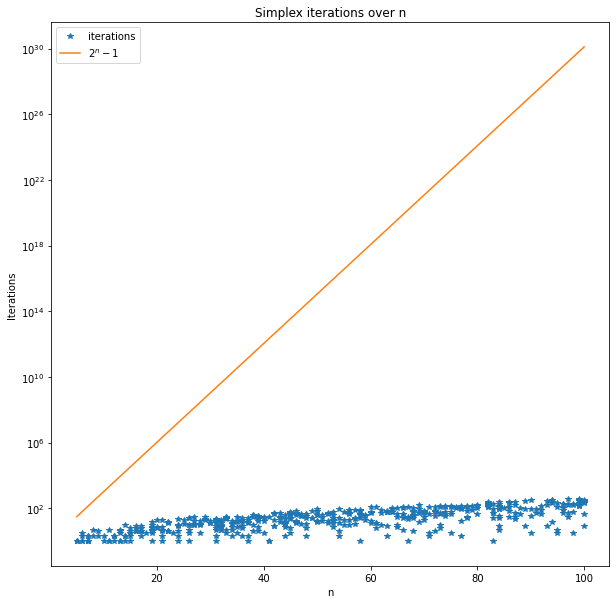

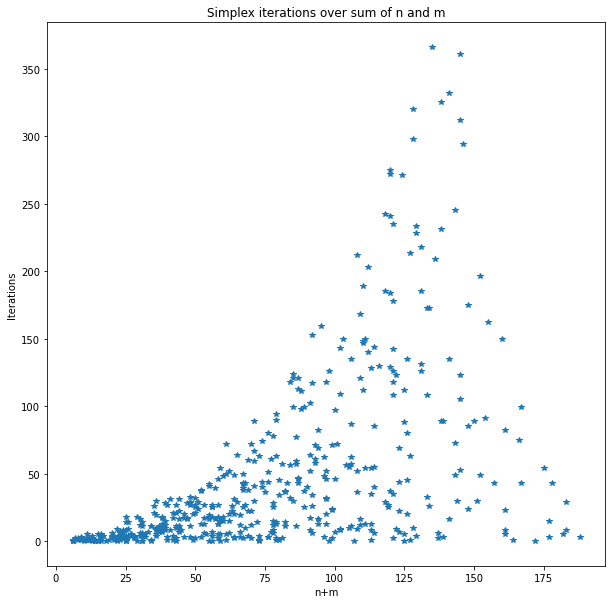

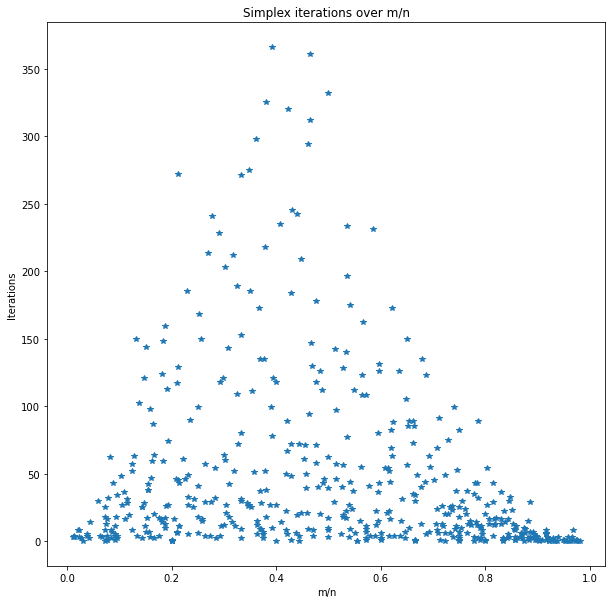

In [7]:
# This script visualizes the performance of the simplex algorithm for various randomly generated data sets.
# The "random" data sets are generated as follows
#
# Set n and set 0 < m < n
# Set x* with m random positive numbers in random positions, other components are zero
# Set s* with n-m random positive numbers and zeros in complementary positions to x^*
# Set A as a mxn matrix with random numbers
# Set b* = Ax*
# Set lam_optbda* as random vector
# Set c = A^T lam_optbda* + s*
#
# This way, the first order optimality conditions are satisfied (which are also sufficient for LPs), i.e.,
# x* is a solution to the LP.
# Note that x* will also be a vertex (a feasible basic vector) - see the number of zero entries.

# Note that generally, A can not be guaranteed to have full rank.

import numpy as np
from visualization_functions import *

# Set parameters for simplex method
simplex_parameters = {
	"max_iterations" : 1000,
	"tol" : 1e-15,
	"verbosity" : "quiet",
	"keep_history" : True
}

# Set parameters for random testing
max_n = 100
min_n = 5
max_random_entry = 100
results = []

# Create pseudo random number generator
rng = np.random.default_rng(np.random.MT19937())

#Get pseudo random data sizes from sampling
number_of_samples = 500
N = rng.integers(min_n,max_n+1,number_of_samples)
M = rng.integers(1, N, number_of_samples)

# Solve test instance for all samples
for n, m in zip(N, M):
	# Dump some output
	print('######################### n = %d, m = %d #########################' % (n,m))
	
	# Create random x_opt with m positive nonzero entries
	x_opt = max_random_entry * rng.random(n)
	x_opt[rng.choice(n, n-m, replace = False)] = 0
	
	# Create random s^* with n-m positive nonzero entries complementary to x_opt
	s_opt = max_random_entry * rng.random(n)
	s_opt = np.where(x_opt > 0, 0, s_opt)
	
	# Create random lambda_opts
	lam_opt = max_random_entry * (rng.random(m) - 0.5)
	
	# Create pseudo random constraint matrix
	A = max_random_entry * (rng.random((m, n)) - 0.5)
	
	# Create constraint rhs
	b = A @ x_opt
	
	# Create cost functional for which x_opt is an optimizer
	c = A.T @ lam_opt + s_opt
	
	# Compute optimal function value
	f_opt = c @ x_opt

	# Start simplex iterations and store results plus problem dimensions
	results.append(primal_simplex_method(A, b, c, B = None, parameters = simplex_parameters))
	results[-1]["n"] = n
	results[-1]["m"] = m
	results[-1]["norm_of_distance"] = np.linalg.norm(results[-1]["solution"]-x_opt)
	results[-1]["diff_in_objective"] = results[-1]["function"]-f_opt

	# Dump some output
	if results[-1]["exitflag"] == 0:
	  print('Solution found.')
	else:
	  print('No solution found.')
	  
	print('Norm of distance between x_opt and solution is: %11.4e' % results[-1]["norm_of_distance"])
	print('Difference in function values between f and f_opt is: %11.4e' % results[-1]["diff_in_objective"])

# Plot iterations over n
plot_simplex_iterations_over_dimension(results)

# Plot iterations over sum of n and m
plot_simplex_iterations_over_sum(results)

# Plot iterations over quotient of m and n
plot_simplex_iterations_over_quotient(results)


**Aufgabe:** Interpretieren Sie die Ergebnisse.

**TODO Ihre Antwort hier**

Die benötigten Iterationen in Abhängigkeit der Problemgröße liegen offensichtlich weit unterhalb des exponentiellen Zusammenhangs, der beim konstruierten Klee-Minty Würfel beobachtet wird. 
Man erkennt sehr gut, dass die Probleme im Allgemeinen schwer zu lösen sind, wenn $m \approx n/2$ ist, was genau mit der Verteilung des Binomialkoeffizienten $\begin{pmatrix} n\\m\end{pmatrix}$ zusammenpasst. 
Für $m\approx n$ ist das System schon fast gleichungsbeschränkt, es gibt wenig Ecken und der Simplex ist entsprechend schnell fertig. Für $m\approx 0$ ist das Problem fast unbeschränkt, es gibt wenig Ecken und der Simplex ist entsprechend schnell fertig.

## Berechnung von Tschebyschow-Zentren
Zuletzt wollen wir noch zurück zu der Übungsaufgabe der *innersten Punkte* in Polyedern - den Tschebyschow Zentren. 
Wir wollen einige davon Berechnen und uns die Lösungseigenschaften etwas genauer ansehen.

**Aufgabe:** Vervollständigen Sie den Code in der folgenden Zelle, in dem Sie mindestens ein Polyeder in je zwei und drei Raumdimensionen konstruieren, dessen Tschebyschow Zentrum berechnen und darstellen.

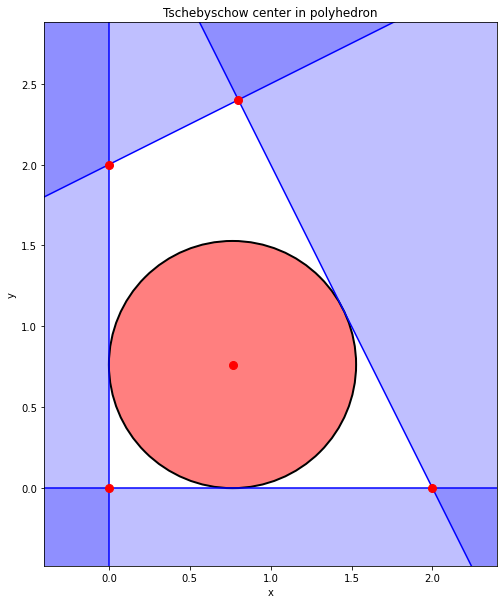

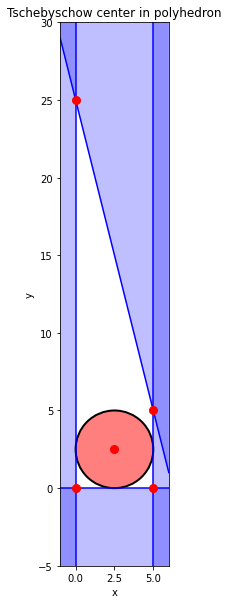

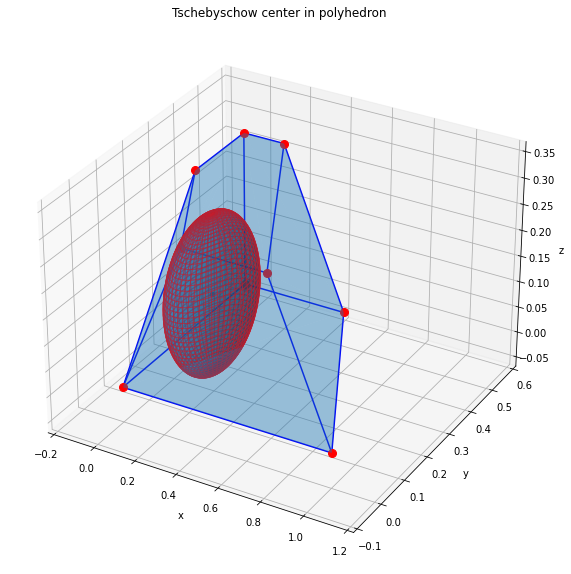

In [8]:
# This module computes the Tschebyschow center for various polyhedra

from visualization_functions import *

def compute_and_plot_tschebyschow_center(halfspace_normals, halfspace_values, initial_bases):
	""" Compute and visualize Tschebyschow center for each polyhedron in list"""
	for normals, values, initial_basis in zip(halfspace_normals, halfspace_values, initial_bases):
		# Get problem dimensions
		m, n = normals.shape

		# Construct data for standard form of Tschebyschow center problem
		A = np.hstack([
			normals, 
			-normals, 
			np.eye(normals.shape[0]), 
			np.array([np.linalg.norm(normals, ord = 2, axis = 1)]).T])
		b = values
		c = np.zeros(A.shape[1])
		c[-1] = -1

		# Set parameters for simplex method
		simplex_parameters = {
			"max_iterations" : 1000,
			"tol" : 1e-15,
			"verbosity" : "quiet",
			"keep_history" : True
		}

		# Solve for Tschebyschow center and radius
		result = primal_simplex_method(A, b, c, B = initial_basis, parameters = simplex_parameters)

		# Reconstruct solution
		sol = result["solution"]
		center = sol[0:n] - sol[n:2*n]
		radius = sol[-1]

		plot_tschebyschow_center(normals, values, center, radius)


# Create some empty containers
halfspace_normals = []
halfspace_values = []
initial_bases = []

# Create data for a 2d polyhedron with unique Tschebyschow center
halfspace_normals.append(np.array([[-1,   0],
                                   [ 0,  -1],
                                   [ 2,   1],
                                   [-0.5, 1]]))
halfspace_values.append(np.array([0, 0, 4, 2]))
initial_bases.append(None)

# Create data for a 2d klee minty cube (3d does not plot well because the axis can not be set equal reasonably, the cube is very skewed
for n in range(2, 3):
	A_klee_minty = np.vstack((np.eye(n), -np.eye(n)))
	for i in range(1, n):
		A_klee_minty[i,0:i] = np.power(2, np.arange(i,0,-1)+1)
	b_klee_minty = np.hstack([np.power(5, np.arange(1, n+1)), np.zeros(n)])
	halfspace_normals.append(A_klee_minty)
	halfspace_values.append(b_klee_minty)
	initial_bases.append(None)

# Create a 3 d polyhedron
halfspace_normals.append(
	np.vstack([
		np.array([[1, 1, 1],
		          [0, 0, 1],
		          [0, 1, 0],
		          [-1, -1, 1]]),
		-np.eye(3)
		]
	)
)
halfspace_values.append(np.hstack([np.array([1, 0.3, 0.5, 0]), np.zeros(3)]))
initial_bases.append(None)

compute_and_plot_tschebyschow_center(halfspace_normals, halfspace_values, initial_bases)

Wir wollen uns nun noch ansehen, welches Verständnis von "Ecken" wir in der Aufgabe der Berechnung von Tschebyschow-Zentren wir entwickeln können.

**Aufgabe:** Berechnen und plotten Sie Lösungen der Tschebyschow-Zentrums-Aufgaben für die von uns vorgegebenen Polyeder indem sie die Folgende Zelle ausführen.

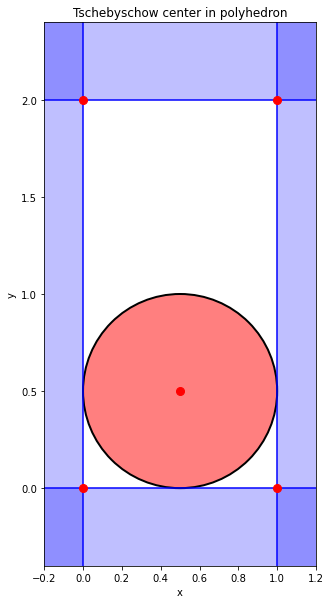

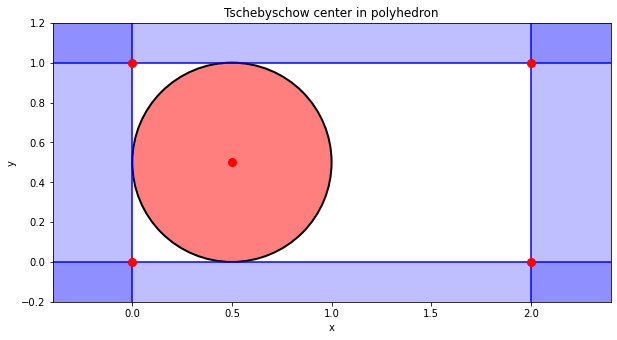

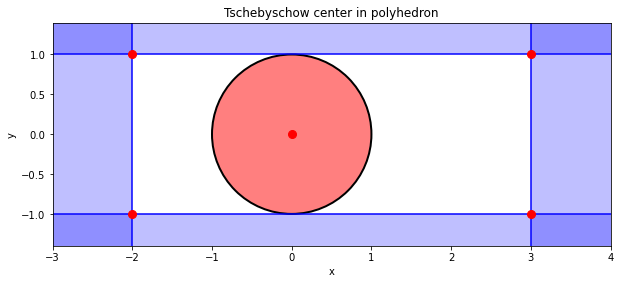

In [9]:
# Create some empty containers
halfspace_normals = []
halfspace_values = []
initial_bases = []

# Create a rectangular polyhedron for "vertex" comparison
halfspace_normals.append(np.array([[-1,   0],
                                   [ 0,  -1],
                                   [ 1,   0],
                                   [ 0,   1]]))
halfspace_values.append(np.array([0, 0, 1, 2]))
initial_bases.append(np.arange(4,8))

# Create a rectangular polyhedron for "vertex" comparison
halfspace_normals.append(np.array([[-1,   0],
                                   [ 0,  -1],
                                   [ 1,   0],
                                   [ 0,   1]]))
halfspace_values.append(np.array([0, 0, 2, 1]))
initial_bases.append(np.arange(4,8))

# Create a special rectangular polyhedron for "vertex" comparison
halfspace_normals.append(np.array([[-1,   0],
                                   [ 0,  -1],
                                   [ 1,   0],
                                   [ 0,   1]]))
halfspace_values.append(np.array([2, 1, 3, 1]))
initial_bases.append(np.arange(4,8))

compute_and_plot_tschebyschow_center(halfspace_normals, halfspace_values, initial_bases)

**Aufgabe:** 
Erklären Sie, warum die Lösung im letzten Fall nur 2, statt 3 Hyperebenen berührt.
Kann es auch einen optimalen Basisvektor in den ersten zwei Fällen geben, der nur zwei Hyperebenen berührt?
Erklären Sie den Zusammenhang von Basislösungen in dem Problem der Tschebyschow-Zentren und der Anzahl der Hyperebenen, die berührt werden.


**TODO Ihre Antwort hier**

Wir wissen, dass Basisvektoren immer höchstens $m$ (Anzahl der Hyperebenen in diesem Fall) Nicht-Null Einträge haben. 
Im Allgemeinen wird einer dieser Nicht-Null-Einträge an einem Optimierer in Normalform von dem Radius belegt sein.
Für jede Hyperebene/jeden Halbraumschnitt ist eine Slackvariable eingeführt worden.
Eine Hyperebene, die nicht berührt wird, bedeutet also immer eine Slackvariable mit Nicht-Null Eintrag, die dann also in der Basis sein muss.
Das heißt, dass jede optimale Basislösung in den x-Komponenten höchstens m-1-#nicht_berührter_Hyperebenen viele Nicht-Null-Einträge haben kann.
Je weniger Hyperebenen wir nicht berühren, desdo mehr Nulleinträge muss also der x-Teil unseres optimalen Basisvektors haben. 
In den ersten beiden Beispielen ist kein Punkt, in dem eine Komponente 0 ist, ein Tschebyschow-Zentrum.
Alle Optimierer werden also 2 Nicht-Null-Einträge im x-Teil haben. 
Es bleibt den optimalen Basislösungen also nichts anderes übrig, als mindestens 3 Hyperebenen zu berühren, damit die dazugehörigen Slackvariablen 0 werden.